# Broadband Data Cleanup.
### Downloaded 2017 MN Fixed internet rates from FCC, removed unnecessary columns to make the file smaller and easier with which to work, grouped by blockcode, and found max and mean speeds for each blockcode.

(Kate Mikkelson)

In [11]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
file = "Resources/MN-Fixed-Dec2017-v2.csv"

In [3]:
mn_broadband = pd.read_csv(file)
mn_broadband.head()

,LogRecNo,Provider_Id,FRN,ProviderName,DBAName,HoldingCompanyName,HocoNum,HocoFinal,StateAbbr,BlockCode,TechCode,Consumer,MaxAdDown,MaxAdUp,Business,MaxCIRDown,MaxCIRUp
0,18268,34062,15093073,"A Better Wireless, NISP, LLC","A Better Wireless, NISP, LLC","A Better Wireless, NISP, LLC",290005,"A Better Wireless, NISP, LLC",MN,271119606002066,70,1,1000.0,1000.0,1,1000.0,1000.0
1,18269,34062,15093073,"A Better Wireless, NISP, LLC","A Better Wireless, NISP, LLC","A Better Wireless, NISP, LLC",290005,"A Better Wireless, NISP, LLC",MN,271119606002068,70,1,1000.0,1000.0,1,1000.0,1000.0
2,18270,34062,15093073,"A Better Wireless, NISP, LLC","A Better Wireless, NISP, LLC","A Better Wireless, NISP, LLC",290005,"A Better Wireless, NISP, LLC",MN,271119606002069,70,1,1000.0,1000.0,1,1000.0,1000.0
3,18271,34062,15093073,"A Better Wireless, NISP, LLC","A Better Wireless, NISP, LLC","A Better Wireless, NISP, LLC",290005,"A Better Wireless, NISP, LLC",MN,271119606002070,70,1,1000.0,1000.0,1,1000.0,1000.0
4,18272,34062,15093073,"A Better Wireless, NISP, LLC","A Better Wireless, NISP, LLC","A Better Wireless, NISP, LLC",290005,"A Better Wireless, NISP, LLC",MN,271119606002071,70,1,1000.0,1000.0,1,1000.0,1000.0


In [4]:
# Clean up dataframe, remove unnecessary columns

mn_broadband = mn_broadband.drop(["LogRecNo", "Provider_Id", "FRN", "ProviderName", "DBAName", "HoldingCompanyName", 
                                 "HocoFinal", "HocoNum", "StateAbbr", "TechCode", "Consumer", "Business", "MaxAdUp", "MaxCIRDown", "MaxCIRUp"], axis=1)
mn_broadband.head()


,BlockCode,MaxAdDown
0,271119606002066,1000.0
1,271119606002068,1000.0
2,271119606002069,1000.0
3,271119606002070,1000.0
4,271119606002071,1000.0


In [5]:
# Rename BlockCode to match grad rate data
mn_broadband = mn_broadband.rename(columns={'BlockCode':'BLOCK'})
mn_broadband.head()

,BLOCK,MaxAdDown
0,271119606002066,1000.0
1,271119606002068,1000.0
2,271119606002069,1000.0
3,271119606002070,1000.0
4,271119606002071,1000.0


In [6]:
# Combine by census block, get max and mean speed for each census block

bycode = mn_broadband.groupby('BLOCK')
bycode.head()

sorted_df = mn_broadband.sort_values("BLOCK")
sorted_df.head()

bc_max_down = bycode["MaxAdDown"].max()
bc_mean_down = bycode["MaxAdDown"].mean()

# Create new dataframe from results
broadband_stats = pd.DataFrame({"Max Down":bc_max_down, "Mean Down":bc_mean_down})

# Save to CSV
broadband_stats.to_csv('Resources/mn_broadband_stats.csv')
broadband_stats.head()


,Max Down,Mean Down
BLOCK,,
270017701001000,30.0,14.25
270017701001001,30.0,14.25
270017701001002,30.0,14.25
270017701001003,30.0,14.25
270017701001004,30.0,14.25


In [8]:
# Import grad rate data
grad_data = pd.read_csv("Resources/district_grouped_mean.csv")

In [9]:
# Merge on census block
merged_data = pd.merge(broadband_stats, grad_data, on="BLOCK")

# Save to CSV
merged_data.to_csv('Resources/broadband_and_gradrates.csv')
merged_data.head()

,BLOCK,Max Down,Mean Down,Four Year Percent,Four Year Total
0,270017701001000,30.0,14.25,89,89
1,270017701001001,30.0,14.25,89,89
2,270017701001002,30.0,14.25,89,89
3,270017701001003,30.0,14.25,90,21
4,270017701001004,30.0,14.25,89,89


In [12]:
# Check Correlations

max_broadband = merged_data['Max Down']
mean_broadband = merged_data['Mean Down']
fcc_high = merged_data['Max Down'] >= 25
fcc_low = merged_data['Max Down'] < 25
grad_rate = merged_data['Four Year Percent']
print("------------")
print('Coefficient of Max Speed vs. Grad Rate')
print(np.corrcoef(max_broadband, grad_rate))
print('Coefficient of Mean Speed vs. Grad Rate')
print(np.corrcoef(mean_broadband, grad_rate))
print('Coefficient of FCC Highspeed Census Blocks vs. Grad Rate')
print(np.corrcoef(fcc_high, grad_rate))
print('Coefficient of FCC Lowspeed Census Blocks vs. Grad Rate')
print(np.corrcoef(fcc_low, grad_rate))
print("------------")


# Check grad rates of schools in FCC High and Low speed Census Blocks
fcc_low_blocks = merged_data.loc[merged_data['Max Down'] < 25, :]
fcc_high_blocks = merged_data.loc[merged_data['Max Down'] >= 25, :]

low_mean_grad_rate = fcc_low_blocks['Four Year Percent'].mean()
high_mean_grad_rate = fcc_high_blocks['Four Year Percent'].mean()
overall_mean = merged_data['Four Year Percent'].mean()
print("Mean grad rate in low speed blocks: " + str(low_mean_grad_rate))
print("Mean grad rate in high speed blocks: " + str(high_mean_grad_rate))
print("Mean grad rate in all blocks: " + str(overall_mean))
print("------------")


#Get the coefficient of determination from your data (Ashley helped with this code to make stats uniform)

from sklearn.linear_model import LinearRegression
broadband_co = np.array(merged_data["Max Down"]).reshape((-1, 1))
gradvariable = np.array(merged_data["Four Year Percent"]) 
yourmodel = LinearRegression().fit(broadband_co, gradvariable)
your_r_sq = yourmodel.score(broadband_co, gradvariable)
print('Coefficient of Determination (Max Down Speed & Grad Rate:', your_r_sq)

------------
Coefficient of Max Speed vs. Grad Rate
[[ 1.         -0.19731916]
 [-0.19731916  1.        ]]
Coefficient of Mean Speed vs. Grad Rate
[[ 1.         -0.19583703]
 [-0.19583703  1.        ]]
Coefficient of FCC Highspeed Census Blocks vs. Grad Rate
[[ 1.         -0.02182271]
 [-0.02182271  1.        ]]
Coefficient of FCC Lowspeed Census Blocks vs. Grad Rate
[[1.         0.02182271]
 [0.02182271 1.        ]]
------------
Mean grad rate in low speed blocks: 85.86037234042553
Mean grad rate in high speed blocks: 82.48307335208608
Mean grad rate in all blocks: 82.51278461712441
------------
Coefficient of Determination (Max Down Speed & Grad Rate: 0.03893485173707201


Low
[[ 1.         -0.07912068]
 [-0.07912068  1.        ]]


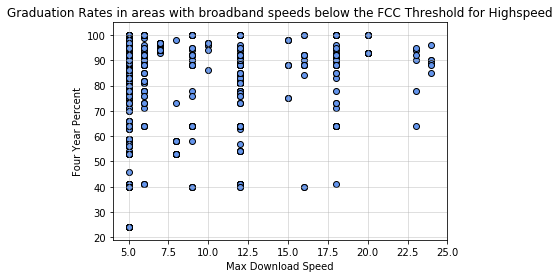

In [13]:
# Graduation Rates in areas with broadband speeds below the FCC Threshold for Highspeed

# Grab just blocks where the max down is below the FCC threshold
fcc_low_blocks = merged_data.loc[merged_data['Max Down'] < 25, :]
fcc_low_blocks.head()

# Grab necessary data as variables for ease of use
fcc_low_speeds = fcc_low_blocks['Max Down']
fcc_low_grad = fcc_low_blocks['Four Year Percent']

# Check correlation coefficient
print('Low')
print(np.corrcoef(fcc_low_speeds, fcc_low_grad))

# Set axes
x_axis = fcc_low_speeds
y_axis = fcc_low_grad

# Set up scatter plot
plt.scatter(x_axis, y_axis, marker="o", facecolors="cornflowerblue", edgecolors="black")
         
# Set limits
plt.xlim((min(fcc_low_speeds)-1), (max(fcc_low_speeds)+1))
plt.ylim((min(grad_rate)-5), (max(grad_rate)+5))
         
# Set titles, labels, formatting
plt.title("Graduation Rates in areas with broadband speeds below the FCC Threshold for Highspeed")
plt.grid(alpha=.5)
plt.xlabel('Max Download Speed')
plt.ylabel('Four Year Percent')

# Show plot and save as .png
plt.savefig("Images/fcc_low_gradrates.png")
plt.show()


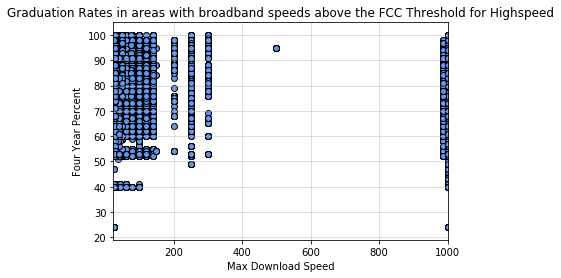

In [15]:
# Graduation Rates in areas with broadband speeds below the FCC Threshold for Highspeed

# Grab just blocks where the max down is below the FCC threshold
fcc_high_blocks = merged_data.loc[merged_data['Max Down'] >= 25, :]
fcc_high_blocks.head()

# Grab necessary data as variables for ease of use
fcc_high_speeds = fcc_high_blocks['Max Down']
fcc_high_grad = fcc_high_blocks['Four Year Percent']

# Set axes
x_axis = fcc_high_speeds
y_axis = fcc_high_grad

# Set up scatter plot
plt.scatter(x_axis, y_axis, marker="o", facecolors="cornflowerblue", edgecolors="black")
         
# Set limits
plt.xlim((min(fcc_high_speeds)-1), (max(fcc_high_speeds)+1))
plt.ylim((min(grad_rate)-5), (max(grad_rate)+5))
         
# Set titles, labels, formatting
plt.title("Graduation Rates in areas with broadband speeds above the FCC Threshold for Highspeed")
plt.grid(alpha=.5)
plt.xlabel('Max Download Speed')
plt.ylabel('Four Year Percent')

# Show plot and save as .png
plt.savefig("Images/fcc_high_gradrates.png")
plt.show()


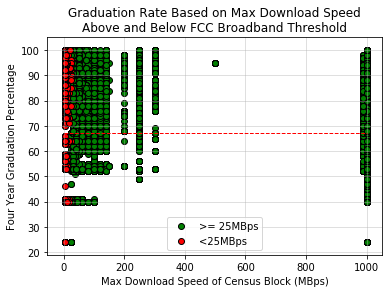

In [19]:
# Scatter plot based on High/Low speed

plt.scatter(fcc_high_speeds, fcc_high_grad, color='green', edgecolors="black", label=">= 25MBps")
plt.scatter(fcc_low_speeds, fcc_low_grad, color='red', edgecolors="black", label="<25MBps")

plt.title("Graduation Rate Based on Max Download Speed\nAbove and Below FCC Broadband Threshold")
plt.xlabel("Max Download Speed of Census Block (MBps)")
plt.ylabel("Four Year Graduation Percentage")
plt.legend(loc="lower center")
plt.grid(alpha=.5)

#Federal Accountability Threshold for Graduation
plt.plot([0,1000], [67,67], color='r', linestyle='--', linewidth=1) 
#plt.annotate('Federal Accountability Threshold', xy=(420, 160), xycoords='figure points')
plt.savefig("Images/gradrates_by_highlow.png")
plt.show()


In [18]:
# Find max speeds above and below the FCC designation of high speed (25MBps)
merged_data['FCC Designation'] = ""

mask = merged_data['Max Down'] >= 25
merged_data['FCC Designation'] = np.where(mask, 'High', 'Low')

merged_data.head()
merged_data['FCC Designation'].value_counts()

High    254185
Low       2256
Name: FCC Designation, dtype: int64

In [ ]:
# Attempting a simpler line chart
grad_rate = merged_data['Four Year Percent']
speed = sorted(merged_data['Max Down'])

plt.plot(speed, grad_rate, linewidth=1)
plt.figure(figsize=(10,8))

plt.savefig("Images/maxdown_grad_line.png")
plt.show()